# Sequential test simulations

Let us present simulations of five (mostly) sequential parametric tests.

Consider Bernoulli random variables *X1,X2,...* iid Alt(*p*)

We always aim to test the hypothesis

H0: *p = p0*

against the alternative

H1: *p = p1*,

where *0 < p0 < p1 < 1*.

The tests can however be used to test the hypotheses H0: *p<= p0* versus H1: *p>=p1*.

On top of vanilla python 3, the code uses
- *numpy* for general math,
- *scipy.stats* for binomial quantiles,
- *matplotlib.pyplot* for image generation.

In [3]:
# import libraries
import math
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [4]:
# auxiliary functions
def gen_X( p ):
    '''
    draw Xi from the pre-specified distribution
    with the parameter value set to 'p'
    '''
    r = np.random.uniform( 0.0, 1.0, 1 )
    return( r < p )

def choose( j, n ):
    return math.factorial( n ) / ( math.factorial( j ) * math.factorial( n-j ) )

## 1) Test with fixed sample size

In [7]:
def L1( p, k, n ):
    '''
    probability of accepting H0 if the true value of the parameter is p a.k.a. operational characteristic
    '''
    return sum( choose( j, n ) * p**j * ( 1-p )**( n-j ) for j in range( int(k) ) )

def eval_k( n, p0, alpha ):
    return binom.ppf( 1-alpha, n, p0 )

In [121]:
n = 100
alpha = 0.05
p = 0.30
p0 = 0.20
p1 = 0.60

In [122]:
def test1( k, verbose = False ):
    x = np.array( [ gen_X( p ) for i in range( n ) ] ) # draw the sample
    Sn = np.sum( x ) # compute test statistic
    L = L1( p, k, n ) # compute operational characteristic
    if verbose:
        print( 'data = \n', np.where( x, 1, 0 ).reshape( -1, 20 ) )
        print( 'Sn = ', Sn )
        print( 'k = ', k)
        print( 'L1 = ', L)
    return( Sn > k) # True - rejected H0, False - not rejected

In [123]:
H = test1( eval_k( n, p0, alpha ), verbose = True )
print( H )

data = 
 [[0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1]
 [0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0]]
Sn =  25
k =  27.0
L1 =  0.22439923974925316
False


Let us see if the level of the test really holds after some more tries:

In [124]:
lvl = 0
for i in range( 1000 ):
    H = test1( eval_k( n, p0, alpha ) )
    if( H ): lvl += 1

print( lvl/1000 )

0.689


And let us take a look at the operational characteristic of this test:

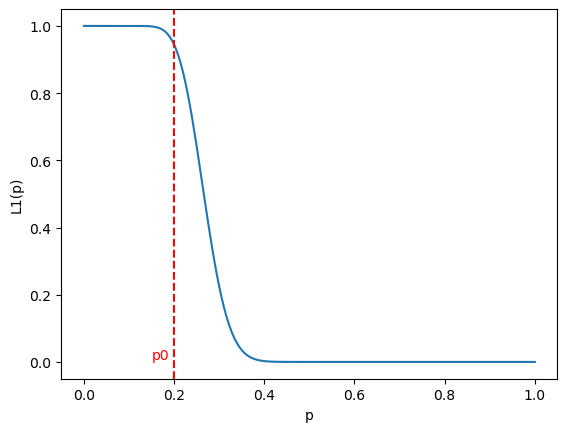

In [128]:
arr_p = np.linspace( 0, 1, 201 )
arr_L = L1( arr_p, eval_k( n, p0, alpha ), n )

plt.plot( arr_p, arr_L )
plt.axvline( x=p0, color='red', linestyle='--' )
plt.xlabel( 'p' )
plt.ylabel( 'L1(p)' )
plt.text(p0-0.01, 0, 'p0', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.show()

We observe a non-increasing function with values between 0 and 1.

It approximately holds that *L1(p0)=1-alpha*, i.e. **P**(type 1 error, *p0*)=*alpha*.

## 2) Two-stage test

In [83]:
n1 = 50
n2 = 50

p = 0.45
p0 = 0.30
p1 = 0.70

def eval_a( n, p0, alpha ):
    return binom.ppf( 1-alpha/2, n, p0 )

def eval_b( n, p1, alpha ):
    return binom.ppf( alpha/2, n, p1 )

def L2( p, a, b, n1, n2 ):
    return L1( p, a, n1 ) + sum( choose( j, n1 ) * p**j * ( 1-p )**( n1-j ) * L1( p, b-j, n2 ) for j in range( int(a+1), int(b) ) )

def EN( p, n1, n2, alpha ):
    a = eval_a( n1, p0, alpha )
    b = eval_b( n1, p1, alpha )
    # print( round( L1( p, b, n1 ), 4 ), round( L1( p, a, n1 ), 4 ) )
    return n1 + n2*( L1( p, b, n1 ) - L1( p, a, n1) )

def test2( n1, n2, alpha, p0, p1, verbose=False ):
    a = eval_a( n1, p0, alpha )
    b = eval_b( n2, p1, alpha )
    x = np.array( [ gen_X( p ) for i in range( n1 ) ] ) # draw the sample
    Sn = np.sum( x ) # test statistic
    if verbose: print( 'Stage one:\na =', a, ', b =', b, ', Sn =', Sn )
    if( Sn <= a ): return False
    elif( Sn > b ): return True
    else:
        x = np.append( x, np.array( [ gen_X( p ) for i in range( n2 ) ] ) ) # extend the sample
        b = eval_b( n1+n2, p1, alpha )
        Sn = np.sum( x ) # recalculate test statistic
        if verbose: print( 'Stage two:\nb =', b, ', Sn =', Sn)
        if( Sn <= b ): return False
        else: return True

In [84]:
print( test2( n1, n2, alpha, p0, p1, verbose = True ) )
print( 'EN =', round( EN( p, n1, n2, alpha ), ndigits = 4) )

Stage one:
a = 22.0 , b = 28.0 , Sn = 19
False
EN = 76.6038


Let us examine the expected sample size for different values of *p*:

In [85]:
arr_p = np.linspace( 0, 1, 201 )
arr_EN = EN( arr_p, n1, n2, alpha )

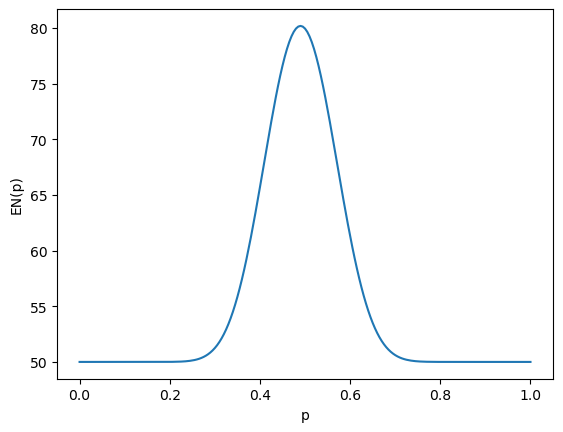

In [86]:
plt.plot( arr_p, arr_EN )
plt.xlabel( 'p' )
plt.ylabel( 'EN(p)' )
plt.show()

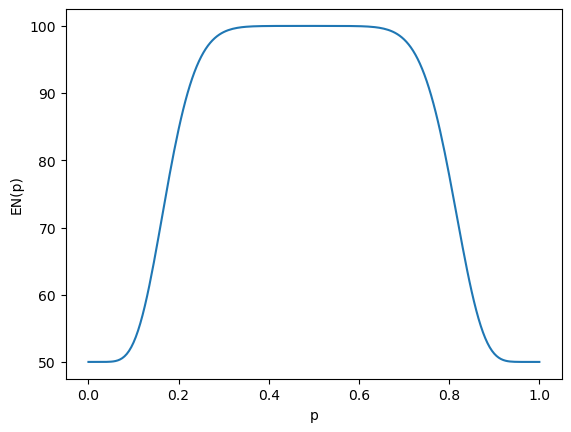

In [87]:
p0 = 0.10
p1 = 0.90

arr_p = np.linspace( 0, 1, 201 )
arr_EN = EN( arr_p, n1, n2, alpha )

plt.plot( arr_p, arr_EN )
plt.xlabel( 'p' )
plt.ylabel( 'EN(p)' )
plt.show()

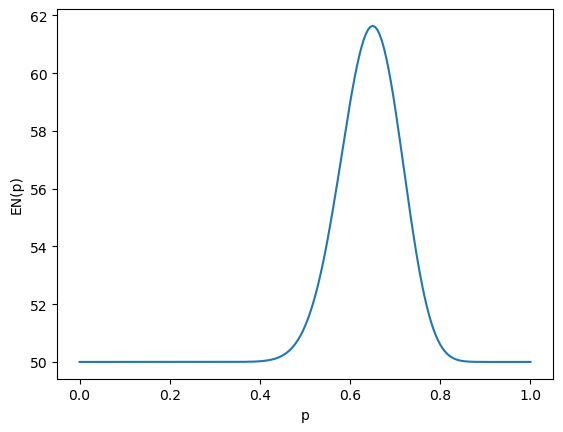

In [102]:
p0 = 0.50
p1 = 0.80

arr_p = np.linspace( 0, 1, 201 )
arr_EN = EN( arr_p, n1, n2, alpha )

plt.plot( arr_p, arr_EN )
plt.xlabel( 'p' )
plt.ylabel( 'EN(p)' )
plt.show()

The function ranges between *n1* and *n1+n2*.

It has a maximum at the average of *p0* and *p1*.